In [2]:
import numpy as np
import csv
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import random
from scipy.optimize import check_grad
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numdifftools as nd
import collections
import pickle as pkl
from sklearn.calibration import CalibratedClassifierCV
import matplotlib
import warnings
import itertools
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import normalized_mutual_info_score

# Load data

In [3]:
with open('../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
    X, screener_ids, refer_ids, Y_observed, Y_human, Y_serv, Y_sub, colnames = pkl.load(handle)

In [4]:
dat_sorted = pd.read_csv("../../data/ChildWelfare/child_welfare_with_call.csv")
dat_sorted = dat_sorted.sort_values(['REFER_DT'])
dat_sorted.drop_duplicates(subset=['MCI_ID'],inplace=True)

In [5]:
df_count = (dat_sorted[colnames]!=0).sum(axis=0)
(pd.DataFrame(df_count)).sort_values(by=0,ascending=False)[0:70]

,0
VIC_COUNT_NULL,46544
POVERYRATE_NULL,45516
PERP_COUNT_NULL,43476
AGE_AT_RFRL_VICT_SELF,40268
NO_BH_VICT_SELF,37683
...,...
DAYS_LAST_SEEN_IN_BH_CHLD,3906
PRNT_AGE_2024_NULL,3473
VIC_OTHER_NULL,3441
DPW_SSI_3_CHLD,3362


In [6]:
D_0_name = 'DPW_SSI_EVERIN_PRNT' #'VIC_AGE_TEEN_NULL'
D_0 = np.array((dat_sorted['DPW_SSI_EVERIN_PRNT']!=0))
Y_2_name = 'DAYS_FROM_LASTRFRL_PERP'
Y_2 = np.array((dat_sorted['DAYS_FROM_LASTRFRL_PERP']!=0))
biasfeat_name = 'TOTAL_C_19_PERP'
biasfeat = (dat_sorted['TOTAL_C_19_PERP']!=0)

In [7]:
X = np.delete(X,np.where(colnames=='TOTAL_C_19_PERP')[0][0],1)

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
X = np.column_stack((X, np.array(biasfeat)[:,np.newaxis]))
X = np.hstack((X, np.ones((X.shape[0],1))))
X = scaler.fit_transform(X)

In [9]:
#colnames
X.shape

(46544, 217)

### Create semi-synthetic labels Y1, Y2, Y using logit models

0.8637159108769895


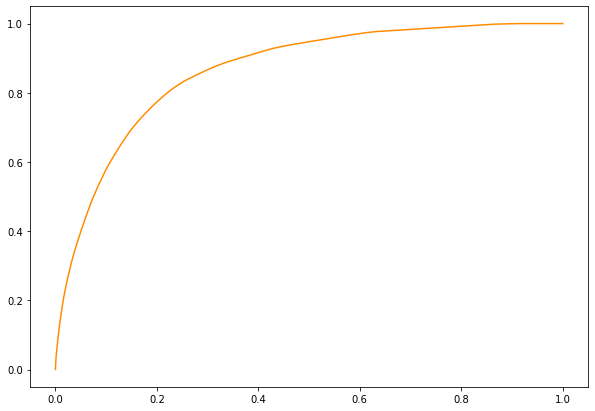

In [61]:
#Fit model to predict Y
from sklearn.tree import DecisionTreeClassifier
plt.rcParams['figure.figsize'] = [10, 7]
tree = DecisionTreeClassifier(random_state=0, min_samples_leaf = 50, max_depth = 15)
clf = tree.fit(X, Y_observed)
Y_pred = clf.predict_proba(X)

fpr, tpr,thres = sklearn.metrics.roc_curve(Y_observed, Y_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)
#coef_pred_y = clf.coef_
#print(sum(coef_pred_y[0]!=0))
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

In [64]:
# plt.rcParams['figure.figsize'] = [30, 10]
# artists = sklearn.tree.plot_tree(tree,fontsize=8)

(array([33190.,  4752.,  3529.,  2225.,  1020.,   743.,   710.,   198.,
          115.,    62.]),
 array([0.        , 0.08064516, 0.16129032, 0.24193548, 0.32258065,
        0.40322581, 0.48387097, 0.56451613, 0.64516129, 0.72580645,
        0.80645161]),
 <a list of 10 Patch objects>)

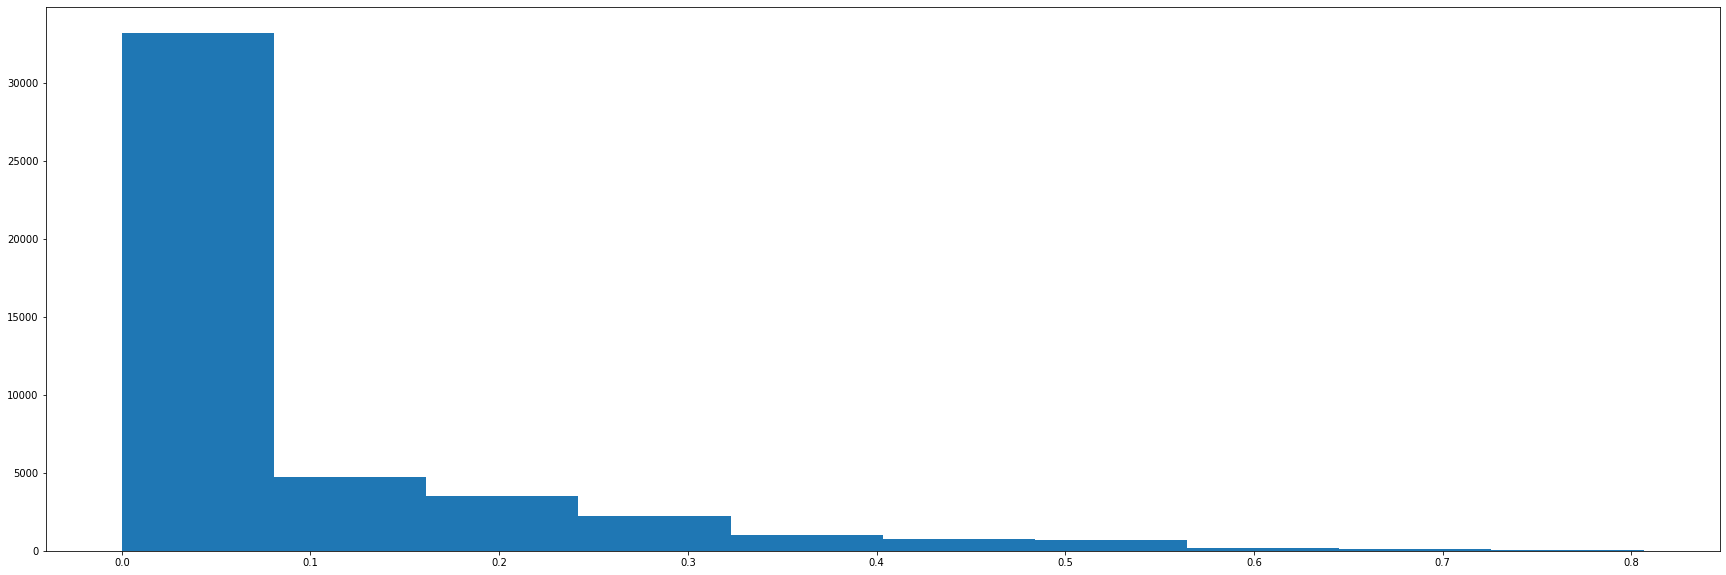

In [63]:
plt.hist(Y_pred[:,1])

In [67]:
sum(Y_pred[:,1]>0.1)

12269

In [68]:
Y_1 = Y_pred[:,1]>0.1
Y = np.array([max(Y_1[i],Y_2[i]) for i in np.arange(len(Y_1))])

In [69]:
print("Number of Y1 = 1: ", sum(Y_1))
print("Number of Y2 = 1: ", sum(Y_2))
print("Number of Y = 1: ", sum(Y))
print("Portion of Y_2=1 for which Y_1=1 ", sum(np.array(Y_1)[Y_2])/np.float(sum(Y_2)))

Number of Y1 = 1:  12269
Number of Y2 = 1:  13762
Number of Y = 1:  21264
Portion of Y_2=1 for which Y_1=1  0.3463886063072228


In [70]:
print('Mutual info Y_1, Y_2: ',normalized_mutual_info_score(Y_1,Y_2))
print('Mutual info Y_1, Y: ',normalized_mutual_info_score(Y_1,Y))
print('Mutual info Y_2, Y: ',normalized_mutual_info_score(Y_2,Y))

Mutual info Y_1, Y_2:  0.012135781297988962
Mutual info Y_1, Y:  0.41945029773843867
Mutual info Y_2, Y:  0.4790783340539268


In [71]:
#Check labels for individuals for whom the 'bias' indicator is on
print(sum(Y_1[np.array(dat_sorted['TOTAL_C_19_PERP']!=0)])/sum(dat_sorted['TOTAL_C_19_PERP']!=0))
print(sum(Y_2[np.array(dat_sorted['TOTAL_C_19_PERP']!=0)])/sum(dat_sorted['TOTAL_C_19_PERP']!=0))
print(sum(Y[np.array(dat_sorted['TOTAL_C_19_PERP']!=0)])/sum(dat_sorted['TOTAL_C_19_PERP']!=0))

0.4264356905552919
0.44803037494067394
0.6763170384432843


### Extract coefficients that will be used to create semi-synthetic human label D

0.9473063223127458


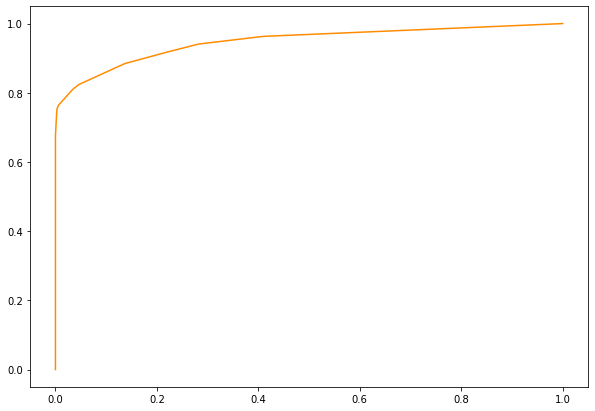

In [77]:
#build model to predict y1, we should be able to recover it almost perfectly
#add noise (sampler from a distribution defined for each decision maker)
plt.rcParams['figure.figsize'] = [10, 7]
tree = DecisionTreeClassifier(random_state=0, min_samples_leaf = 50, max_depth = 5)
clf = tree.fit(X, Y)
Y_pred = clf.predict_proba(X)
fpr, tpr,thres = sklearn.metrics.roc_curve(Y, Y_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

0.9909859069001281


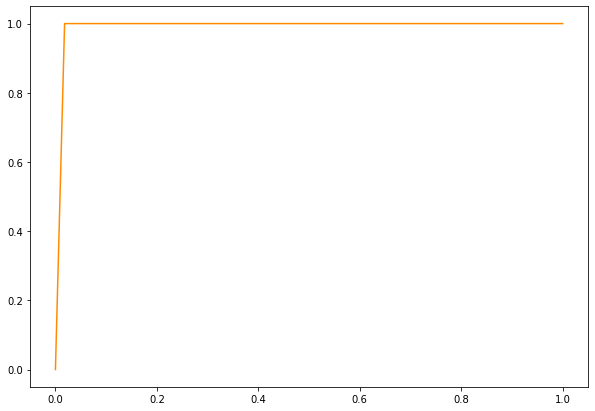

In [78]:
fpr, tpr,thres = sklearn.metrics.roc_curve(Y_2, Y_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

0.7275093935787473


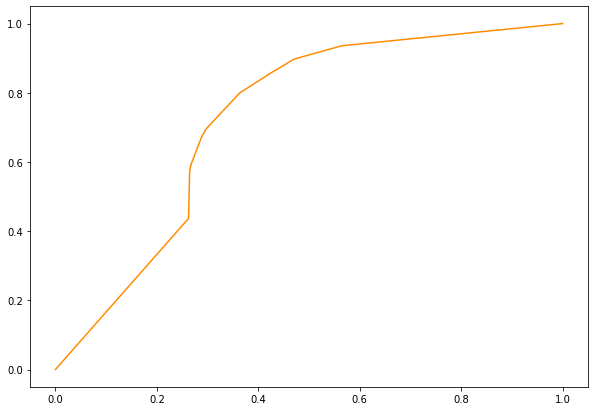

In [79]:
fpr, tpr,thres = sklearn.metrics.roc_curve(Y_1, Y_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)

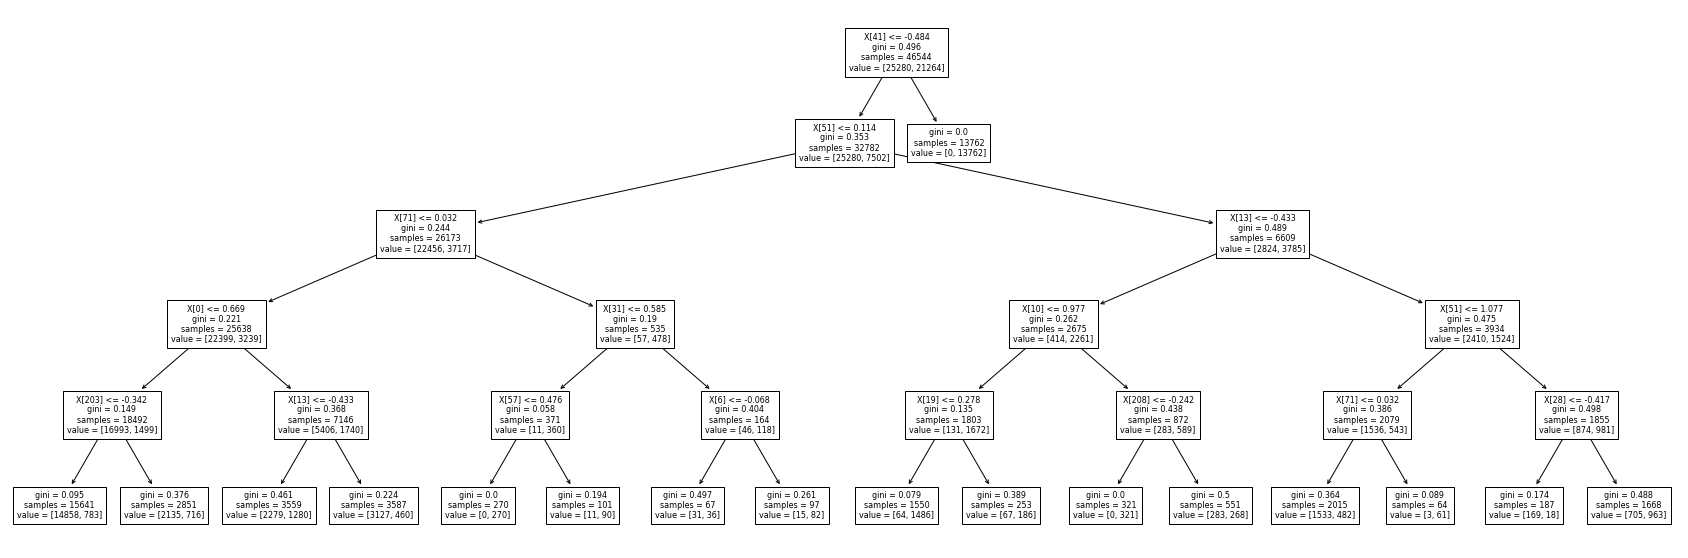

In [74]:
artists = sklearn.tree.plot_tree(tree,fontsize=8)

## Pickle data 

In [80]:
# with open('../../data/semi_synthetic/X.pkl', 'wb') as file:
#     pkl.dump(X,file)
with open('../../data/semi_synthetic/Data_semisynthetic_tree.pkl', 'wb') as file:
    pkl.dump([X,Y_1,Y_2,Y,D_0,refer_ids,screener_ids,tree],file)

In [21]:
# with open('../../data/semi_synthetic/labels.pkl', 'rb') as handle:
#     b = pkl.load(handle)